HOMEWORK

Giacomo Filippin, Emma Lovato

In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

Methods' definition

In [2]:
def softmax(z):
    if sp.issparse(z):
        z_max = z.max(axis=1).toarray()
        exp_z = np.exp(z - z_max)
        sum_exp_z = exp_z.sum(axis=1)
        return exp_z / sum_exp_z
    else:
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_cost(X, y, weights):
    m = X.shape[0]
    logits = X.dot(weights)
    probs = softmax(logits)
    if hasattr(y, "toarray"):
        y = y.toarray()
    log_likelihood = -np.sum(y * np.log(probs + 1e-10)) / m
    return log_likelihood

def compute_accuracy(X, y_sparse, weights):
    y_pred = predict(X, weights)
    y_true = y_sparse.argmax(axis=1).A1
    accuracy = np.mean(y_pred == y_true)
    return accuracy

def gradient_descent(X, y, X_val, y_val, weights, learning_rate, num_epochs):
    m, n = X.shape
    trainloss_history = []
    valloss_history = []
    trainacc_history = []
    valacc_history = []

    for epoch in range(num_epochs):
        logits = X.dot(weights)
        probs = softmax(logits)
        gradient = X.T.dot(probs - y) / m
        weights -= learning_rate * gradient

        if epoch % 5 == 0:
            train_cost = compute_cost(X, y, weights)
            val_cost = compute_cost(X_val, y_val, weights)
            train_accuracy = compute_accuracy(X, y, weights)
            val_accuracy = compute_accuracy(X_val, y_val, weights)
        
            trainloss_history.append(train_cost)
            valloss_history.append(val_cost)
            trainacc_history.append(train_accuracy)
            valacc_history.append(val_accuracy)

            print(f'Epoch {epoch} completed')
            print(f'Train Cost: {train_cost}, Train Accuracy: {train_accuracy}')
            print(f'Validation Cost: {val_cost}, Validation Accuracy: {val_accuracy}')
    
    return weights, trainloss_history, valloss_history, trainacc_history, valacc_history

def gauss_southwell_rule(gradient, block_size):
    n = gradient.shape[0]
    n_blocks = (n + block_size - 1) // block_size
    norms = [np.linalg.norm(gradient[i*block_size:(i+1)*block_size]) for i in range(n_blocks)]
    return np.argmax(norms)

def block_coordinate_gradient_descent_gs(X, y, X_val, y_val, weights, learning_rate, num_epochs, block_size):
    m, n = X.shape
    n_blocks = (n + block_size - 1) // block_size
    trainloss_history = []
    valloss_history = []
    trainacc_history = []
    valacc_history = []
    
    for epoch in range(num_epochs):
        logits = X.dot(weights)
        probs = softmax(logits)
        gradient = X.T.dot(probs - y) / m
        
        # Chooses the block to opdate with the max norm of the gradient
        block_idx = gauss_southwell_rule(gradient, block_size)
        start = block_idx * block_size
        end = min((block_idx + 1) * block_size, n)
        
        # updates selected block
        weights[start:end, :] -= learning_rate * gradient[start:end, :]

        if epoch % 5 == 0:        
            train_cost = compute_cost(X, y, weights)
            val_cost = compute_cost(X_val, y_val, weights)
            train_accuracy = compute_accuracy(X, y, weights)
            val_accuracy = compute_accuracy(X_val, y_val, weights)
        
            trainloss_history.append(train_cost)
            valloss_history.append(val_cost)
            trainacc_history.append(train_accuracy)
            valacc_history.append(val_accuracy)

            print(f'Epoch {epoch} completed')
            print(f'Train Cost: {train_cost}, Train Accuracy: {train_accuracy}')
            print(f'Validation Cost: {val_cost}, Validation Accuracy: {val_accuracy}')
    
    return weights, trainloss_history, valloss_history, trainacc_history, valacc_history

def predict(X, weights):
    logits = X.dot(weights)
    return np.argmax(logits, axis=1)

PART A:

Data generation & processing

In [3]:
d = 1000  # Number of features
K = 50  # Number of classes
m = 1000   # Number of observations
# Sampling A, X, E from a normal distribution N(0,1)
A = np.random.normal(0, 1, (m, d))  # data matrix of 1000x1000
X = np.random.normal(0, 1, (d, K))  # parameters
E = np.random.normal(0, 1, (m, K))  # Noise
# Computing AX + E
AX = A.dot(X) + E
# Checking the shape of the result for verification
print("Shape of AX:", AX.shape)
# Finding the indices of the maximum values along each column (axis 0)
b = np.argmax(AX, axis=1)

print("b:", b)

Shape of AX: (1000, 50)
b: [21 37 11 32 12 31 38  6 19 19 21 35 34 49  8 42 14 23 27 16 34  8 46 28
 27  2 47 45 25 43 15 34 11  2 25 14 11 33 48 23 15 44  5  8 48 25 26 36
 14 23 43 46 37 25 17  0 13 29 12 14 11 33  2 29 12 37 45 10 45  5 41 34
 48 26 36 35 25 36  6 37 28 20 24  9  3 25 45  7 37  6  2  0 24  9 35 45
 42 38 46 48 29 37 14 34 28 43 13  5 44 29 13 36 21 47 41 28  6  7 39  4
 37 43 48  9 40  5 15 16 13 19 17 35 23 15 19 32 43 38  3 38 14 34 32 25
 20 42  4 31 36 29 33 44 29 34 32 10  0 11 44 47  4 34 11 30 26 36 18 43
 16  3 41 38 46 38 13 15 31 18 40 35 16 26 35  8 24 21 20  1 10 43 10 17
 38 46 32 10 31  9 11 43 27 31 35 23 38  2 22 14 39 48 30 42  0 24  9 46
 20 36 49  2  1 45 46 13 34 26 30 18  3 31 32 42 33 14 37 26 35  2 41  3
 38 34 48  6 39 43 33  0 49 22 22 20 38  4 11 44 10 22 42 38  8 38  5 24
 33 40  5 23 34 46 29 21 14 13 12 25 12 18 36 10 32  5 45 44 17 41  8 11
 39 41 13 47 47 37 40  0 49 13 14 14 49  2 41 22 24 28  7  5 43 48 20 22
 40 36 10  9 35 26 37 33

In [4]:
X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=0.4, random_state=42)
# Print shapes of the transformed data
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (600, 1000)
X_test shape: (400, 1000)
y_train shape: (600,)
y_test shape: (400,)


In [5]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

C:\Users\giaco\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
# divides the test set in validation and test set
X_val, X_test, y_val_one_hot, y_test_one_hot = train_test_split(X_test, y_test_one_hot, test_size=0.5, random_state=42)
# sparse format
X_train_sparse = sp.csr_matrix(X_train)
X_val_sparse = sp.csr_matrix(X_val)
X_test_sparse = sp.csr_matrix(X_test)
y_train_sparse = sp.csr_matrix(y_train_one_hot)
y_val_sparse = sp.csr_matrix(y_val_one_hot)
y_test_sparse = sp.csr_matrix(y_test_one_hot)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train_one_hot shape: {y_train_one_hot.shape}')
print(f'y_val_one_hot shape: {y_val_one_hot.shape}')
print(f'y_test_one_hot shape: {y_test_one_hot.shape}')

X_train shape: (600, 1000)
X_val shape: (200, 1000)
X_test shape: (200, 1000)
y_train_one_hot shape: (600, 50)
y_val_one_hot shape: (200, 50)
y_test_one_hot shape: (200, 50)


"\nnum_samples, num_features = X.shape\ninitial_density = (X.nnz / (num_samples * num_features)) * 100\ninitial_sparsity = 100 - initial_density  # Sparsity is the complement of density\nprint(f'Initial Density: {initial_density:.2f}%')\nprint(f'Initial Sparsity: {initial_sparsity:.2f}%')\n"

Parameters' definition

In [7]:
n_features = X_train.shape[1]
n_classes = y_train_one_hot.shape[1]
learning_rate_GD = 0.01
learning_rate_BCGD = 0.8

num_epochs = 200
block_size = 125

np.random.seed(42)
weights_init = X
print(weights_init.shape)

(1000, 50)


Standard Gradient descend training

In [8]:
weights_gd = weights_init.copy()
weights_gd, trainloss_history_gd, valloss_history_gd, trainacc_history_gd, valacc_history_gd = gradient_descent(X_train_sparse, y_train_sparse, X_val_sparse, y_val_sparse, weights_gd, learning_rate_GD, num_epochs)

Epoch 0 completed
Train Cost: 0.08161626752195991, Train Accuracy: 0.9716666666666667
Validation Cost: 0.10074921387258616, Validation Accuracy: 0.955
Epoch 5 completed
Train Cost: 0.0778984210902447, Train Accuracy: 0.9716666666666667
Validation Cost: 0.10072100645198635, Validation Accuracy: 0.955
Epoch 10 completed
Train Cost: 0.07440184045835364, Train Accuracy: 0.9716666666666667
Validation Cost: 0.10069367168173869, Validation Accuracy: 0.955
Epoch 15 completed
Train Cost: 0.07111586628195685, Train Accuracy: 0.9766666666666667
Validation Cost: 0.10066719037557455, Validation Accuracy: 0.955
Epoch 20 completed
Train Cost: 0.06802983756734053, Train Accuracy: 0.98
Validation Cost: 0.10064154184681023, Validation Accuracy: 0.955
Epoch 25 completed
Train Cost: 0.06513316400997347, Train Accuracy: 0.9816666666666667
Validation Cost: 0.10061670422999329, Validation Accuracy: 0.955
Epoch 30 completed
Train Cost: 0.062415391184682485, Train Accuracy: 0.9816666666666667
Validation Cost: 

BCGD with GS rule training

In [9]:
weights_bcgd_gs = weights_init.copy()
weights_bcgd_gs, trainloss_history_bcgd_gs, valloss_history_bcgd_gs, trainacc_history_bcgd_gs, valacc_history_bcgd_gs = block_coordinate_gradient_descent_gs(X_train_sparse, y_train_sparse, X_val_sparse, y_val_sparse, weights_bcgd_gs, learning_rate_BCGD, num_epochs, block_size)

Epoch 0 completed
Train Cost: 0.07472815974837432, Train Accuracy: 0.9733333333333334
Validation Cost: 0.10055066492299272, Validation Accuracy: 0.955
Epoch 5 completed
Train Cost: 0.04859474486367958, Train Accuracy: 0.9916666666666667
Validation Cost: 0.09997334645827474, Validation Accuracy: 0.955
Epoch 10 completed
Train Cost: 0.035056912789869894, Train Accuracy: 1.0
Validation Cost: 0.09951269962670567, Validation Accuracy: 0.955
Epoch 15 completed
Train Cost: 0.02748288176356486, Train Accuracy: 1.0
Validation Cost: 0.09921619895297536, Validation Accuracy: 0.955
Epoch 20 completed
Train Cost: 0.022770117124013306, Train Accuracy: 1.0
Validation Cost: 0.09897498207188, Validation Accuracy: 0.955
Epoch 25 completed
Train Cost: 0.019563327813386936, Train Accuracy: 1.0
Validation Cost: 0.09877054757095383, Validation Accuracy: 0.955
Epoch 30 completed
Train Cost: 0.017232242323526912, Train Accuracy: 1.0
Validation Cost: 0.0985911782766162, Validation Accuracy: 0.955
Epoch 35 comp

Results analysis

Classic Gradient Descent's accuracy on test set: 0.935
BCGD with Gauss-Southwell Rule's accuracy on test set: 0.935


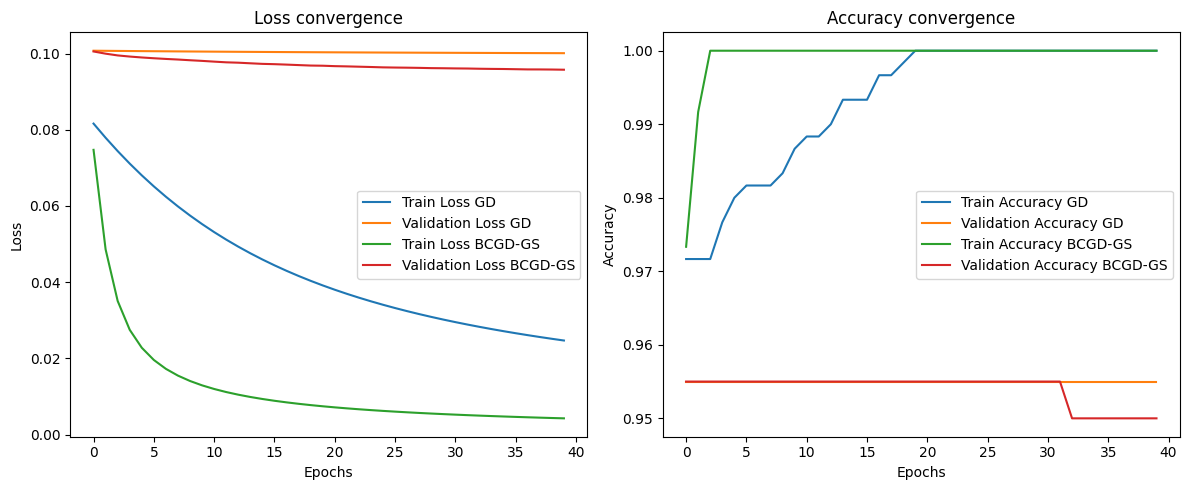

In [10]:
accuracy_gd = compute_accuracy(X_test, y_test_sparse, weights_gd)
accuracy_bcgd_gs = compute_accuracy(X_test, y_test_sparse, weights_bcgd_gs)

print(f"Classic Gradient Descent's accuracy on test set: {accuracy_gd}")
print(f"BCGD with Gauss-Southwell Rule's accuracy on test set: {accuracy_bcgd_gs}")


# Loss plot across training and validation set
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainloss_history_gd, label='Train Loss GD')
plt.plot(valloss_history_gd, label='Validation Loss GD')
plt.plot(trainloss_history_bcgd_gs, label='Train Loss BCGD-GS')
plt.plot(valloss_history_bcgd_gs, label='Validation Loss BCGD-GS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss convergence')
plt.legend()

# Accuracy plot across training and validation set
plt.subplot(1, 2, 2)
plt.plot(trainacc_history_gd, label='Train Accuracy GD')
plt.plot(valacc_history_gd, label='Validation Accuracy GD')
plt.plot(trainacc_history_bcgd_gs, label='Train Accuracy BCGD-GS')
plt.plot(valacc_history_bcgd_gs, label='Validation Accuracy BCGD-GS')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy convergence')
plt.legend()

plt.tight_layout()
plt.show()

PART B:

Data download & preprocessing

In [4]:
# Load the dataset
newsgroups = fetch_20newsgroups(subset='all', categories=None, shuffle=True, random_state=42)

# Transform texts to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(newsgroups.data)
y = newsgroups.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Print shapes of the transformed data
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (11307, 10000)
X_test shape: (7539, 10000)
y_train shape: (11307,)
y_test shape: (7539,)


In [7]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

C:\Users\giaco\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Standardize the features
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# divides the test set in validation and test set
X_val, X_test, y_val_one_hot, y_test_one_hot = train_test_split(X_test, y_test_one_hot, test_size=0.5, random_state=42)

# sparse format
X_train_sparse = sp.csr_matrix(X_train)
X_val_sparse = sp.csr_matrix(X_val)
X_test_sparse = sp.csr_matrix(X_test)
y_train_sparse = sp.csr_matrix(y_train_one_hot)
y_val_sparse = sp.csr_matrix(y_val_one_hot)
y_test_sparse = sp.csr_matrix(y_test_one_hot)
X = sp.csr_matrix(X)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train_one_hot shape: {y_train_one_hot.shape}')
print(f'y_val_one_hot shape: {y_val_one_hot.shape}')
print(f'y_test_one_hot shape: {y_test_one_hot.shape}')

num_samples, num_features = X.shape
initial_density = (X.nnz / (num_samples * num_features)) * 100
initial_sparsity = 100 - initial_density  # Sparsity is the complement of density
print(f'Initial Density: {initial_density:.2f}%')
print(f'Initial Sparsity: {initial_sparsity:.2f}%')

X_train shape: (11307, 10000)
X_val shape: (1885, 10000)
X_test shape: (1885, 10000)
y_train_one_hot shape: (11307, 20)
y_val_one_hot shape: (1885, 20)
y_test_one_hot shape: (1885, 20)
Initial Density: 0.88%
Initial Sparsity: 99.12%


Hyperparameters' definition

In [12]:
n_features = X_train_sparse.shape[1]
n_classes = y_train_sparse.shape[1]
learning_rate_GD = 0.01
learning_rate_BCGD = 0.8

num_epochs = 200
block_size = 125

np.random.seed(42)
weights_init = np.random.randn(n_features, n_classes) * 0.01

Standard Gradient descend training

In [13]:
weights_gd = weights_init.copy()
weights_gd, trainloss_history_gd, valloss_history_gd, trainacc_history_gd, valacc_history_gd = gradient_descent(X_train_sparse, y_train_sparse, X_val_sparse, y_val_sparse, weights_gd, learning_rate_GD, num_epochs)

Epoch 0 completed
Train Cost: 3.3987508471903585, Train Accuracy: 0.05147253913504909
Validation Cost: 3.457378917852419, Validation Accuracy: 0.06737400530503979
Epoch 5 completed
Train Cost: 3.0897307662459315, Train Accuracy: 0.10223755195896347
Validation Cost: 3.1770992031587157, Validation Accuracy: 0.10822281167108753
Epoch 10 completed
Train Cost: 2.8050861810096, Train Accuracy: 0.16874502520562484
Validation Cost: 2.918692137817465, Validation Accuracy: 0.16392572944297082
Epoch 15 completed
Train Cost: 2.549005679025314, Train Accuracy: 0.24595383390819847
Validation Cost: 2.6865022082180974, Validation Accuracy: 0.23076923076923078
Epoch 20 completed
Train Cost: 2.3218463993181118, Train Accuracy: 0.33182983992217213
Validation Cost: 2.4811561790824506, Validation Accuracy: 0.29814323607427057
Epoch 25 completed
Train Cost: 2.121957910494542, Train Accuracy: 0.4082426815247192
Validation Cost: 2.3009481659690554, Validation Accuracy: 0.35915119363395226
Epoch 30 completed
T

BCGD with GS rule training

In [14]:
weights_bcgd_gs = weights_init.copy()
weights_bcgd_gs, trainloss_history_bcgd_gs, valloss_history_bcgd_gs, trainacc_history_bcgd_gs, valacc_history_bcgd_gs = block_coordinate_gradient_descent_gs(X_train_sparse, y_train_sparse, X_val_sparse, y_val_sparse, weights_bcgd_gs, learning_rate_BCGD, num_epochs, block_size)

Epoch 0 completed
Train Cost: 3.368461264585241, Train Accuracy: 0.05996285486866543
Validation Cost: 3.427782559711383, Validation Accuracy: 0.07639257294429708
Epoch 5 completed
Train Cost: 2.965555306761409, Train Accuracy: 0.15043778190501458
Validation Cost: 3.070626823062382, Validation Accuracy: 0.1496021220159151
Epoch 10 completed
Train Cost: 2.633941637015237, Train Accuracy: 0.24683824179711683
Validation Cost: 2.7609532370327052, Validation Accuracy: 0.22387267904509284
Epoch 15 completed
Train Cost: 2.35649739670321, Train Accuracy: 0.33793225435570884
Validation Cost: 2.500197757097156, Validation Accuracy: 0.3050397877984085
Epoch 20 completed
Train Cost: 2.125187796251509, Train Accuracy: 0.41531794463606614
Validation Cost: 2.2876927960531046, Validation Accuracy: 0.36710875331564985
Epoch 25 completed
Train Cost: 1.9331715981816076, Train Accuracy: 0.47899531263818873
Validation Cost: 2.128385550839357, Validation Accuracy: 0.4196286472148541
Epoch 30 completed
Train 

Results analysis

Classic Gradient Descent's accuracy on test set: 0.7877984084880637
BCGD with Gauss-Southwell Rule's accuracy on test set: 0.7925729442970822


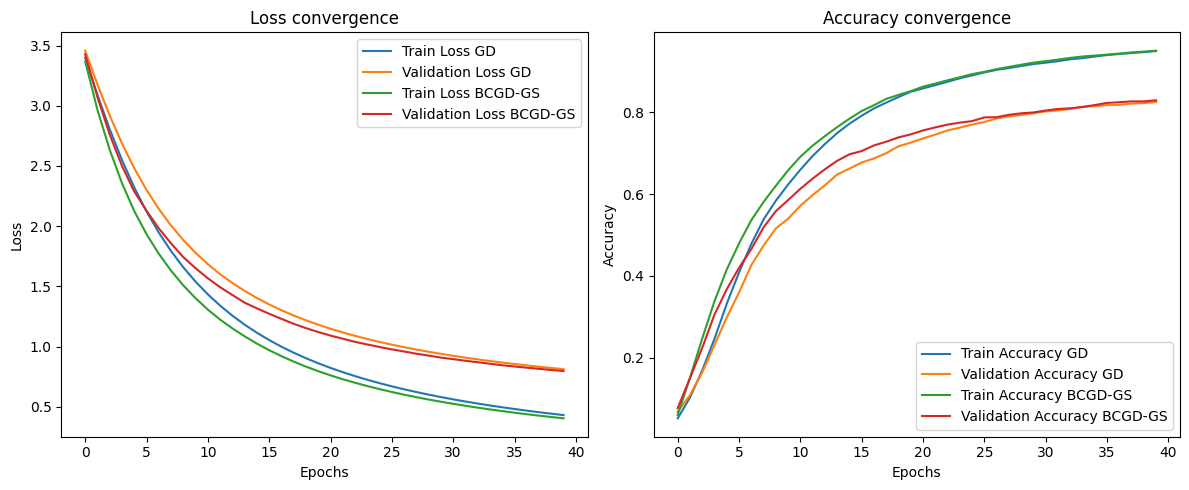

In [17]:
accuracy_gd = compute_accuracy(X_test_sparse, y_test_sparse, weights_gd)
accuracy_bcgd_gs = compute_accuracy(X_test_sparse, y_test_sparse, weights_bcgd_gs)

print(f"Classic Gradient Descent's accuracy on test set: {accuracy_gd}")
print(f"BCGD with Gauss-Southwell Rule's accuracy on test set: {accuracy_bcgd_gs}")


# Loss plot across training and validation set
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainloss_history_gd, label='Train Loss GD')
plt.plot(valloss_history_gd, label='Validation Loss GD')
plt.plot(trainloss_history_bcgd_gs, label='Train Loss BCGD-GS')
plt.plot(valloss_history_bcgd_gs, label='Validation Loss BCGD-GS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss convergence')
plt.legend()

# Accuracy plot across training and validation set
plt.subplot(1, 2, 2)
plt.plot(trainacc_history_gd, label='Train Accuracy GD')
plt.plot(valacc_history_gd, label='Validation Accuracy GD')
plt.plot(trainacc_history_bcgd_gs, label='Train Accuracy BCGD-GS')
plt.plot(valacc_history_bcgd_gs, label='Validation Accuracy BCGD-GS')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy convergence')
plt.legend()

plt.tight_layout()
plt.show()
